In [43]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from data_utils import *
from eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lstm import LSTMModel
from cnnlstm import CNNLSTMModel
from lstmattn import LSTMAttentionModel
from transformer import TransformerModel

In [44]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [47]:
data_dir = '../data/'

test_data = np.load(data_dir + 'OA_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [48]:
X_test = test_data['X_test']
y_test = test_data['y_test']

print(X_test.shape, y_test.shape)

(843, 100, 3) (843, 100, 9)


In [49]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [50]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=2, 
                       output_size=9, 
                       dropout=0.08941182342943683)

lstm_model.load_state_dict(torch.load('../models/lstm.pth', weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True, dropout=0.08941182342943683)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [51]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 27653.796875


In [52]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.1409
tibant: 0.1059
edl: 0.0889
ehl: 0.0251
fdl: 0.0392
fhl: 0.0626
perbrev: 0.1111
perlong: 0.0803
achilles: 0.0732


In [53]:
lstm_mae = calc_mae_muscle(y_test, lstm_pred)

tibpost: 138.1268
tibant: 78.8372
edl: 14.5128
ehl: 3.0923
fdl: 7.7290
fhl: 29.9379
perbrev: 14.5713
perlong: 46.2243
achilles: 294.8085


In [54]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: -0.7952
tibant: -0.1526
edl: 0.0019
ehl: -0.1763
fdl: -0.6330
fhl: -0.7906
perbrev: -0.0968
perlong: -0.0865
achilles: 0.6820


In [55]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=3, 
                             output_size=9, 
                             dropout=0.17575462419723403)

cnnlstm_model.load_state_dict(torch.load('../models/cnn-lstm.pth', weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.17575462419723403)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [56]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 35016.39453125


In [57]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.1657
tibant: 0.1290
edl: 0.0950
ehl: 0.0275
fdl: 0.0454
fhl: 0.0719
perbrev: 0.1144
perlong: 0.0814
achilles: 0.0815


In [58]:
cnnlstm_mae = calc_mae_muscle(y_test, cnnlstm_pred)

tibpost: 165.0427
tibant: 92.9703
edl: 14.8736
ehl: 3.2867
fdl: 9.3106
fhl: 35.1172
perbrev: 14.9205
perlong: 46.4209
achilles: 340.6736


In [59]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: -1.4821
tibant: -0.7115
edl: -0.1383
ehl: -0.4147
fdl: -1.1905
fhl: -1.3581
perbrev: -0.1626
perlong: -0.1164
achilles: 0.6057


In [60]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=3, 
                                    num_heads=8, 
                                    output_size=9, 
                                    lstm_dropout=0.08509082023364795, 
                                    attn_dropout=0.3104457129518861)

lstmattn_model.load_state_dict(torch.load('../models/lstm-attn.pth', weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.08509082023364795)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [61]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 35058.8984375


In [62]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.1441
tibant: 0.0902
edl: 0.0940
ehl: 0.0242
fdl: 0.0370
fhl: 0.0654
perbrev: 0.1160
perlong: 0.0820
achilles: 0.0852


In [63]:
lstmattn_mae = calc_mae_muscle(y_test, lstmattn_pred)

tibpost: 140.2997
tibant: 66.8999
edl: 15.0520
ehl: 2.8766
fdl: 7.3155
fhl: 31.2741
perbrev: 15.2011
perlong: 47.3288
achilles: 301.9358


In [64]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: -0.8786
tibant: 0.1632
edl: -0.1146
ehl: -0.0974
fdl: -0.4606
fhl: -0.9554
perbrev: -0.1944
perlong: -0.1327
achilles: 0.5696


In [65]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=32, 
                                     nhead=8, 
                                     num_encoder_layers=6, 
                                     dim_feedforward=256, 
                                     dropout=0.012122943820592716)

transformer_model.load_state_dict(torch.load('../models/transformer.pth', weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=32, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=256, bias=True)
        (dropout): Dropout(p=0.012122943820592716, inplace=False)
        (linear2): Linear(in_features=256, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.012122943820592716, inplace=False)
        (dropout2): Dropout(p=0.012122943820592716, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features=9, bias=True)
)

In [66]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 22073.158203125


In [67]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.1608
tibant: 0.0984
edl: 0.0971
ehl: 0.0249
fdl: 0.0437
fhl: 0.0726
perbrev: 0.1104
perlong: 0.0809
achilles: 0.0611


In [68]:
transformer_mae = calc_mae_muscle(y_test, transformer_pred)

tibpost: 159.3891
tibant: 78.2536
edl: 15.0138
ehl: 2.8160
fdl: 8.9673
fhl: 35.2006
perbrev: 14.5568
perlong: 46.7438
achilles: 258.2665


In [69]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: -1.3396
tibant: 0.0044
edl: -0.1883
ehl: -0.1617
fdl: -1.0321
fhl: -1.4094
perbrev: -0.0817
perlong: -0.1022
achilles: 0.7785


In [70]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 166.29430518026143
CNN-LSTM RMSE Overall: 187.12667860285381
LSTM-Attention RMSE Overall: 187.24021465780837
Transformer RMSE Overall: 148.5703821104571


In [71]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.02758918454230766
CNN-LSTM RRMSE Overall: 0.0310453954701993
LSTM-Attention RRMSE Overall: 0.031064231756679172
Transformer RRMSE Overall: 0.02464868345986568


In [72]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.08332976122104459
CNN-LSTM RRMSE Weighted: 0.09405464951297016
LSTM-Attention RRMSE Weighted: 0.08907056961138159
Transformer RRMSE Weighted: 0.07924620503298495


In [73]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 2.509430808152768
CNN-LSTM RMSPE: 3.606311306736949
LSTM-Attention RMSPE: 2.2604040804538865
Transformer RMSPE: 2.510715801829145


In [74]:
lstm_mae_overall = calc_mae_overall(y_test, lstm_pred)
print(f"LSTM MAE Overall: {lstm_mae_overall}")

cnnlstm_mae_overall = calc_mae_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Overall: {cnnlstm_mae_overall}")

lstmattn_mae_overall = calc_mae_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Overall: {lstmattn_mae_overall}")

transformer_mae_overall = calc_mae_overall(y_test, transformer_pred)
print(f"Transformer MAE Overall: {transformer_mae_overall}")

LSTM MAE Overall: 69.76001400680795
CNN-LSTM MAE Overall: 80.29069080321143
LSTM-Attention MAE Overall: 69.79816658819296
Transformer MAE Overall: 68.80083121028672


In [75]:
lstm_mae_weighted = calc_mae_weighted(y_test, lstm_pred)
print(f"LSTM MAE Weighted: {lstm_mae_weighted}")

cnnlstm_mae_weighted = calc_mae_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Weighted: {cnnlstm_mae_weighted}")

lstmattn_mae_weighted = calc_mae_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Weighted: {lstmattn_mae_weighted}")

transformer_mae_weighted = calc_mae_weighted(y_test, transformer_pred)
print(f"Transformer MAE Weighted: {transformer_mae_weighted}")

LSTM MAE Weighted: 0.05654057551145292
CNN-LSTM MAE Weighted: 0.06507570175921518
LSTM-Attention MAE Weighted: 0.05657149822469315
Transformer MAE Weighted: 0.05576315669770836


In [78]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.8139763285320756
CNN-LSTM R2: 0.7644490412881586
LSTM-Attention R2: 0.7641631211842851
Transformer R2: 0.8515165880452971


In [79]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.8139763285320756
CNN-LSTM R2: 0.7644490412881586
LSTM-Attention R2: 0.7641631211842851
Transformer R2: 0.8515165880452971


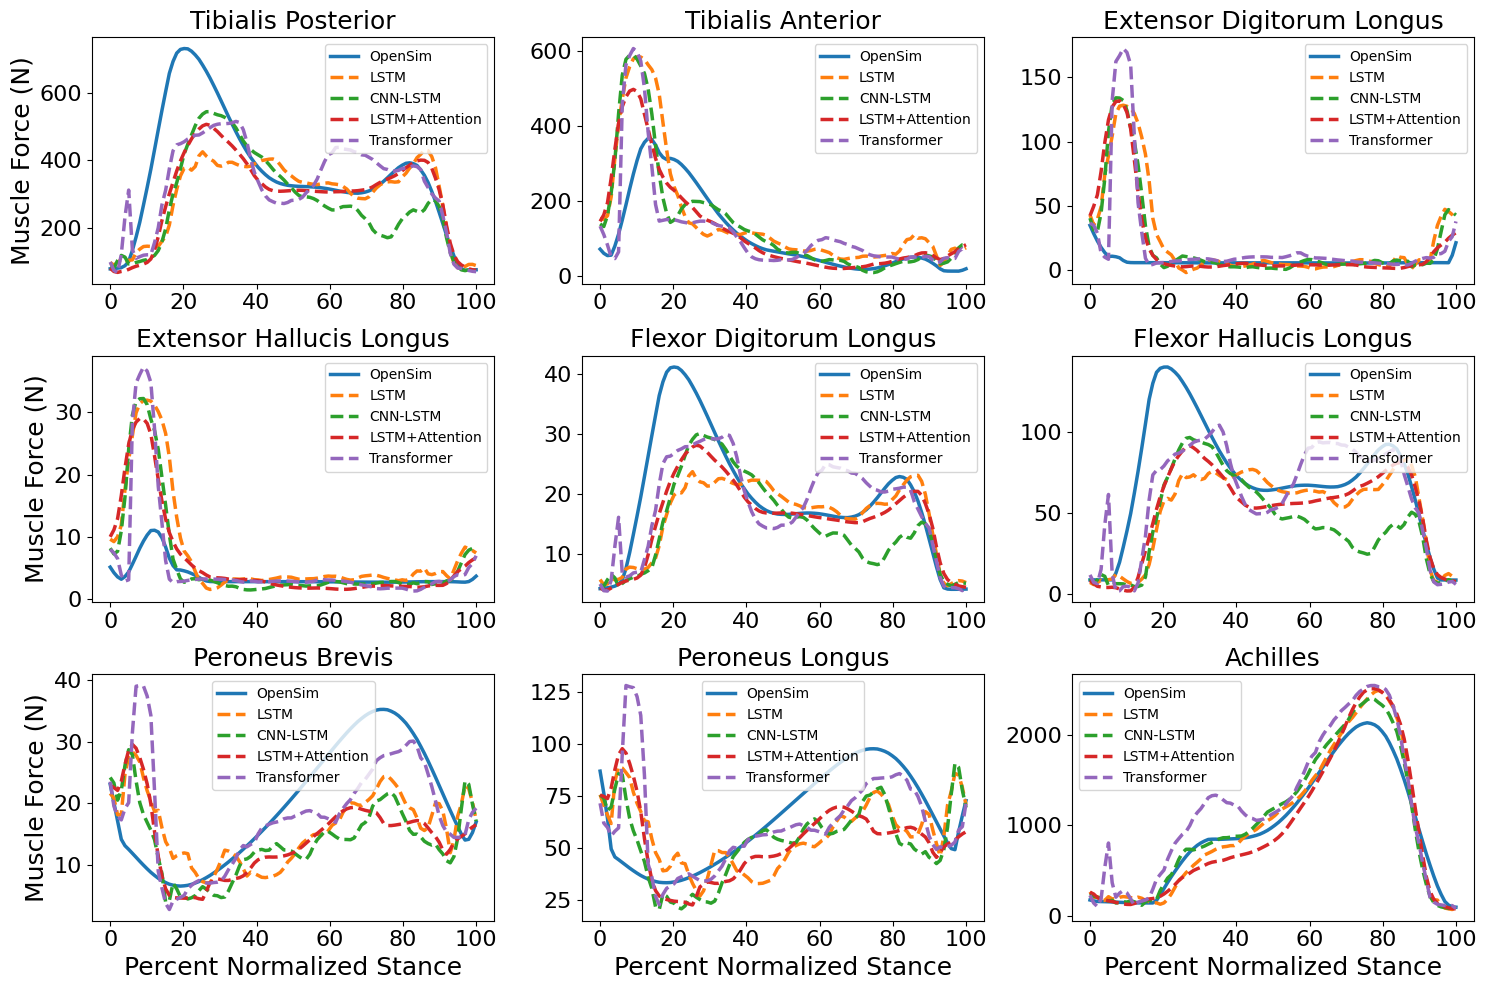

In [82]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()
plt.tight_layout()
plt.show()


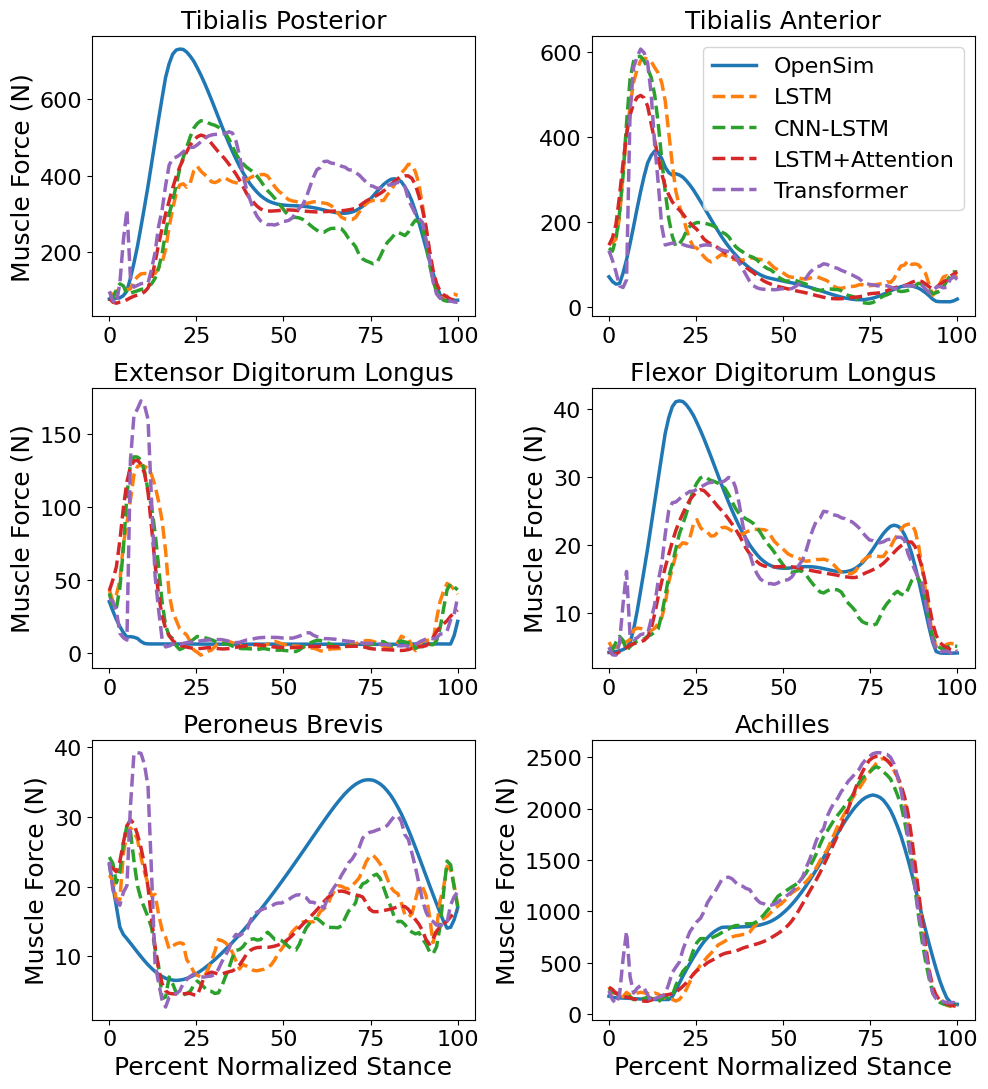

In [81]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

plot_idx = [0, 1, 2, 4, 6, 8]

fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in zip(plot_idx, axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 2 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [37]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.0430 & 0.0345 & 0.0336 & 0.0342 \\
{Tibialis Anterior} & 0.0251 & 0.0194 & 0.0191 & 0.0190 \\
{Extensor Digitorum Longus} & 0.0195 & 0.0144 & 0.0148 & 0.0121 \\
{Extensor Hallucis Longus} & 0.0067 & 0.0056 & 0.0063 & 0.0057 \\
{Flexor Digitorum Longus} & 0.0114 & 0.0094 & 0.0110 & 0.0096 \\
{Flexor Hallucis Longus} & 0.0214 & 0.0174 & 0.0177 & 0.0174 \\
{Peroneus Brevis} & 0.0112 & 0.0097 & 0.0101 & 0.0095 \\
{Peroneus Longus} & 0.0215 & 0.0182 & 0.0189 & 0.0170 \\
{Achilles} & 0.0149 & 0.0126 & 0.0118 & 0.0130 \\
\midrule
Overall & 0.0207 & 0.0169 & 0.0166 & 0.0167 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [38]:
mae_muscle_dict = {'LSTM': lstm_mae, 'CNN-LSTM': cnnlstm_mae, 'LSTM+Attention': lstmattn_mae, 'Transformer': transformer_mae}
mae_overall_dict = {'LSTM': lstm_mae_weighted, 'CNN-LSTM': cnnlstm_mae_weighted, 'LSTM+Attention': lstmattn_mae_weighted, 'Transformer': transformer_mae_weighted}

mae_table = generate_latex_table(mae_muscle_dict, mae_overall_dict, muscle_titles)
print(mae_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 41.6380 & 32.5547 & 32.6264 & 32.7998 \\
{Tibialis Anterior} & 18.5041 & 14.2477 & 14.7871 & 14.2274 \\
{Extensor Digitorum Longus} & 4.8785 & 3.5339 & 4.0111 & 3.1329 \\
{Extensor Hallucis Longus} & 0.7742 & 0.6156 & 0.8933 & 0.7072 \\
{Flexor Digitorum Longus} & 2.4214 & 1.9596 & 2.4947 & 2.0666 \\
{Flexor Hallucis Longus} & 10.1040 & 8.1907 & 8.5935 & 8.1351 \\
{Peroneus Brevis} & 3.6214 & 2.9864 & 3.2402 & 2.9945 \\
{Peroneus Longus} & 12.2750 & 9.5677 & 10.1561 & 8.8975 \\
{Achilles} & 45.2614 & 37.4696 & 37.3222 & 40.6598 \\
\midrule
Overall & 0.0137 & 0.0109 & 0.0112 & 0.0112 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [39]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.8631 & 0.9123 & 0.9164 & 0.9135 \\
{Tibialis Anterior} & 0.9442 & 0.9667 & 0.9678 & 0.9681 \\
{Extensor Digitorum Longus} & 0.8396 & 0.9124 & 0.9079 & 0.9384 \\
{Extensor Hallucis Longus} & 0.9111 & 0.9379 & 0.9204 & 0.9357 \\
{Flexor Digitorum Longus} & 0.8438 & 0.8935 & 0.8527 & 0.8891 \\
{Flexor Hallucis Longus} & 0.8301 & 0.8868 & 0.8834 & 0.8877 \\
{Peroneus Brevis} & 0.7440 & 0.8101 & 0.7931 & 0.8188 \\
{Peroneus Longus} & 0.6778 & 0.7696 & 0.7526 & 0.7995 \\
{Achilles} & 0.9946 & 0.9961 & 0.9966 & 0.9958 \\
\midrule
Overall & 0.9954 & 0.9969 & 0.9971 & 0.9968 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [40]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE



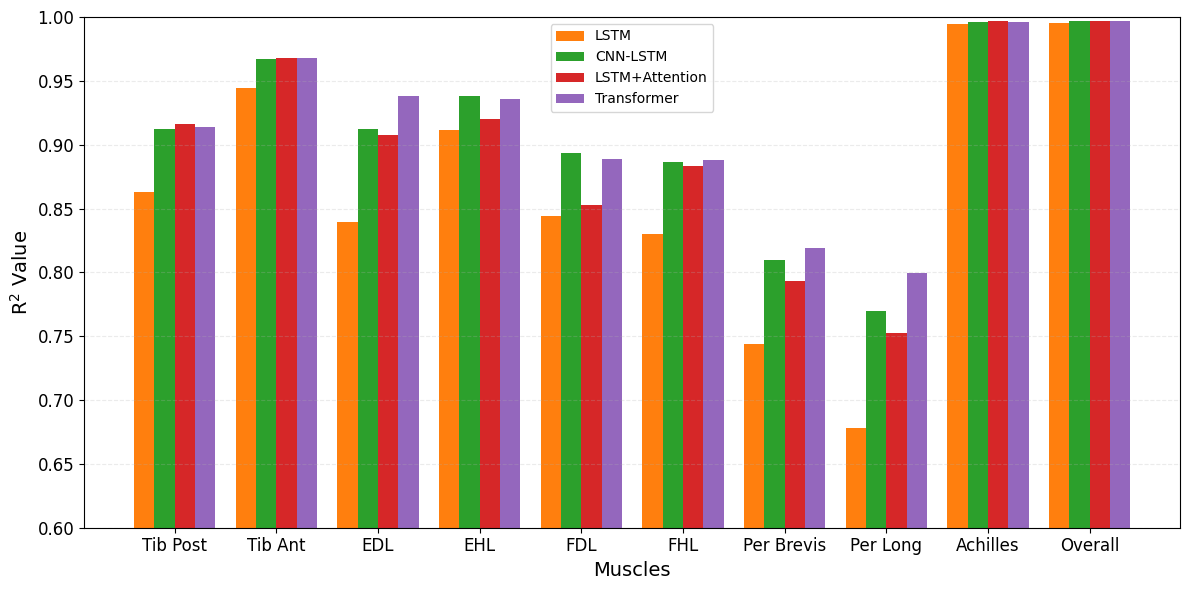

In [41]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

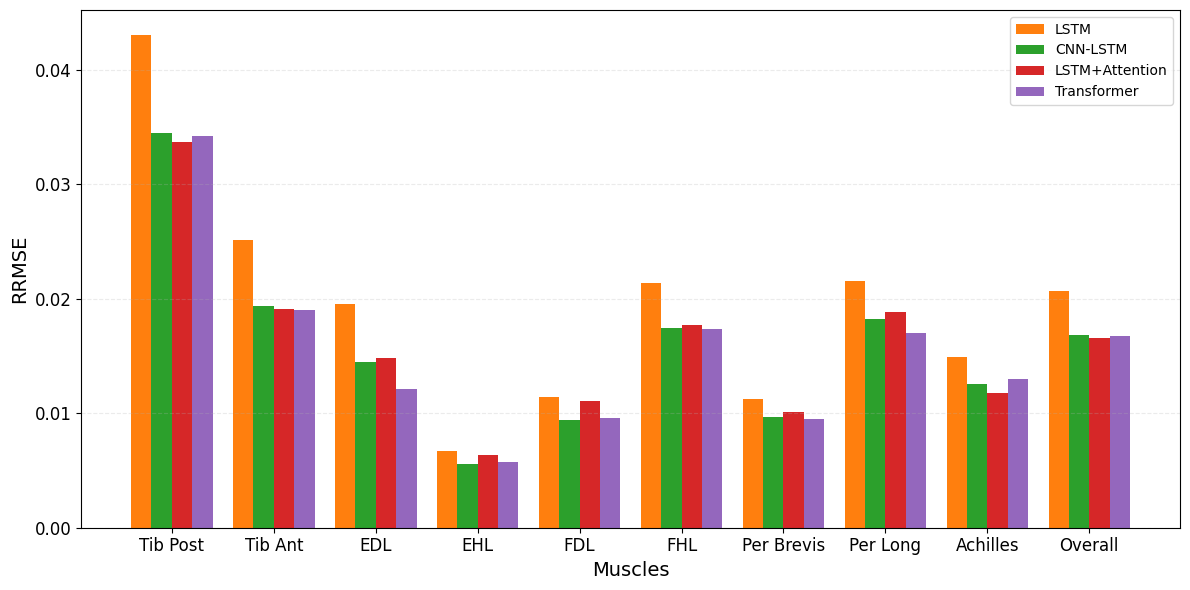

In [42]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()